# Task-2 Stock Prediction

# Task-2

In [4]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import optuna
from tensorflow.keras.models import load_model
import os

# Load and Preprocess the Data

In [3]:
df=pd.read_csv('NKE.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-23,53.060001,53.950001,53.000000,53.660000,50.422565,12242600
1,2017-10-24,53.900002,54.000000,53.099998,53.419998,50.197041,14767600
2,2017-10-25,53.430000,55.910000,52.669998,54.939999,51.625347,24804000
3,2017-10-26,55.259998,57.250000,55.139999,56.810001,53.382526,22185100
4,2017-10-27,55.820000,56.360001,55.650002,55.959999,52.583801,12801800


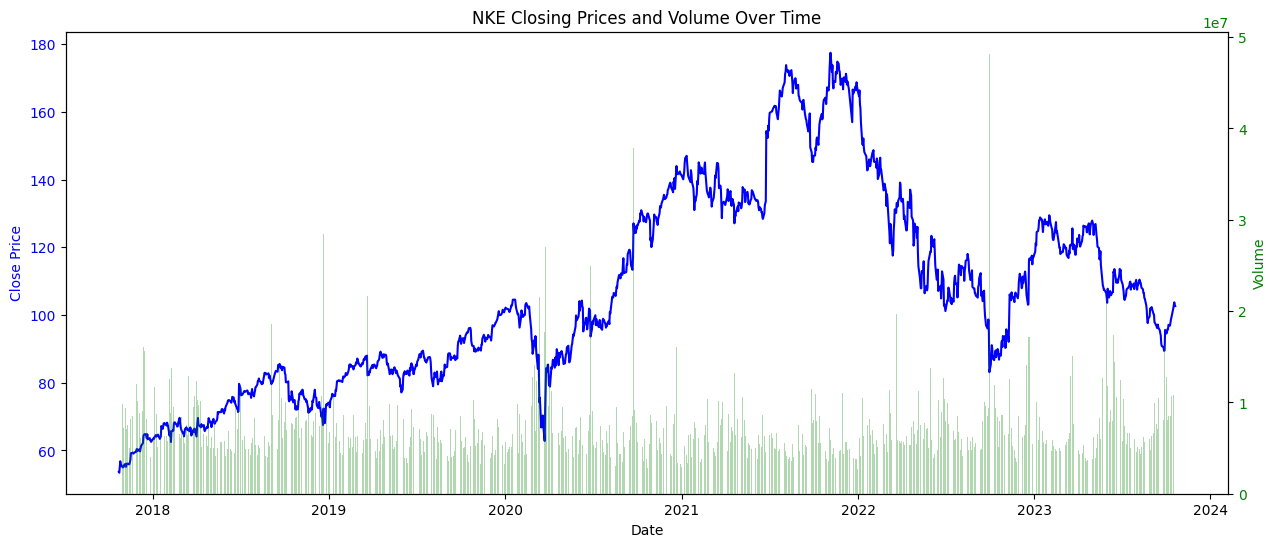

In [5]:
df = df.copy()
df['Date'] = pd.to_datetime(df['Date'])

fig, ax1 = plt.subplots(figsize=(15, 6))

# Plotting the Closing price on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.plot(df['Date'], df['Close'], color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='green')
ax2.bar(df['Date'], df['Volume'], color='green', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='green')

plt.title('NKE Closing Prices and Volume Over Time')
plt.show()


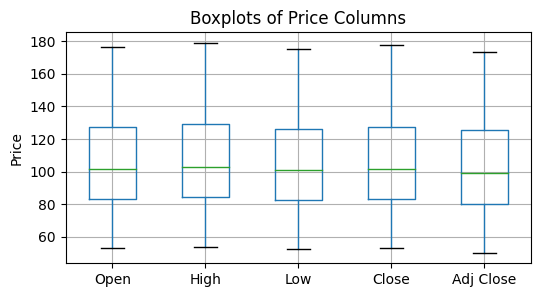

In [6]:
plt.figure(figsize=(6,3))
df.boxplot(column=['Open', 'High', 'Low', 'Close', 'Adj Close'])
plt.title('Boxplots of Price Columns')
plt.ylabel('Price')
plt.show()

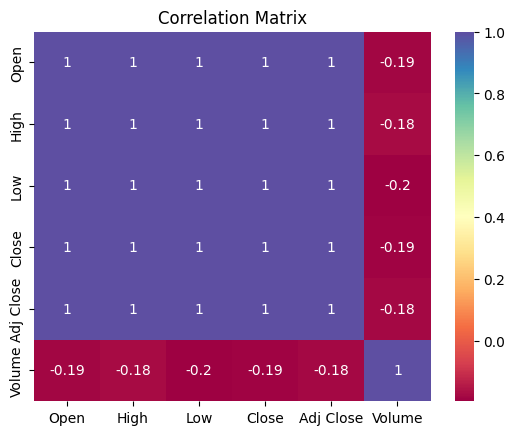

In [7]:
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Spectral')
plt.title('Correlation Matrix')
plt.show()

In [8]:
# Handle missing values by interpolation
df.interpolate(method='linear', inplace=True)

In [9]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = pd.DataFrame(scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]), columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
df['Date'] = pd.to_datetime(df['Date'])
scaled_data['Date'] = df['Date']

In [10]:
#checking the data
scaled_data.head()

,Open,High,Low,Close,Adj Close,Volume,Date
0,0.000000,0.000000,0.002687,0.001934,0.001827,0.224806,2017-10-23
1,0.006813,0.000400,0.003501,0.000000,0.000000,0.279278,2017-10-24
2,0.003001,0.015661,0.000000,0.012249,0.011569,0.495793,2017-10-25
3,0.017844,0.026368,0.020109,0.027319,0.025802,0.439296,2017-10-26
4,0.022386,0.019257,0.024261,0.020469,0.019333,0.236870,2017-10-27


In [11]:
seq_length = 10  # Define the sequence length

X = []
y = []

for i in range(len(scaled_data) - seq_length):
    x = scaled_data[i:i+seq_length].drop('Date', axis=1).values
    X.append(x)
    y.append(scaled_data.iloc[i+seq_length]['Close'])

X = np.array(X)
y = np.array(y)

In [12]:
X

array([[[0.00000000e+00, 0.00000000e+00, 2.68665631e-03, 1.93409627e-03,
         1.82674835e-03, 2.24805951e-01],
        [6.81321247e-03, 3.99512569e-04, 3.50077337e-03, 0.00000000e+00,
         0.00000000e+00, 2.79277822e-01],
        [3.00104619e-03, 1.56611979e-02, 0.00000000e+00, 1.22491823e-02,
         1.15693036e-02, 4.95793261e-01],
        ...,
        [1.91418355e-02, 1.23851293e-02, 1.77481069e-02, 1.32968171e-02,
         1.25587532e-02, 1.23453754e-01],
        [1.69519094e-02, 1.09468553e-02, 1.56313764e-02, 1.36997425e-02,
         1.29393082e-02, 1.17106972e-01],
        [1.69519094e-02, 1.41430278e-02, 1.92949846e-02, 1.84543562e-02,
         1.74300308e-02, 1.64522309e-01]],

       [[6.81321247e-03, 3.99512569e-04, 3.50077337e-03, 0.00000000e+00,
         0.00000000e+00, 2.79277822e-01],
        [3.00104619e-03, 1.56611979e-02, 0.00000000e+00, 1.22491823e-02,
         1.15693036e-02, 4.95793261e-01],
        [1.78440823e-02, 2.63683489e-02, 2.01091017e-02, 2.731890

In [13]:
y[:10]

array([0.02111373, 0.01394153, 0.01885728, 0.02183901, 0.02151666,
       0.0200661 , 0.0206302 , 0.02586835, 0.03070354, 0.04649852])

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Model Selection

In [53]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(30))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [54]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
18/18 [==============================] - 9s 122ms/step - loss: 0.0749 - val_loss: 0.0197
Epoch 2/50
18/18 [==============================] - 0s 22ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 3/50
18/18 [==============================] - 0s 21ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 4/50
18/18 [==============================] - 0s 22ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/50
18/18 [==============================] - 0s 21ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/50
18/18 [==============================] - 0s 21ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/50
18/18 [==============================] - 0s 21ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/50
18/18 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/50
18/18 [==============================] - 0s 25ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/50
18/18 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11

# Evaluation on MSE

In [55]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE on test data: {mse}")

12/12 [==============================] - 2s 10ms/step
MSE on test data: 0.0008276218211523903


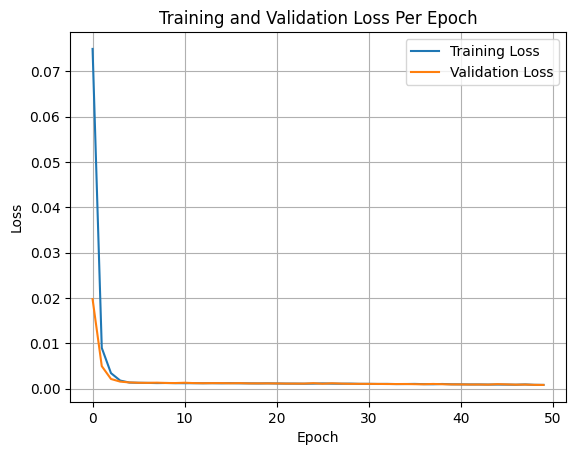

In [56]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Hyperparameter Tuning

In [44]:
# Create lists to store hyperparameter options
lstm_units_options = [30, 50, 70, 100]
learning_rate_options = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = None
best_mse = float('inf')

In [45]:
# Loop through hyperparameter options
for lstm_units in lstm_units_options:
    for learning_rate in learning_rate_options:
        # Build the LSTM model with current hyperparameters
        model = Sequential()
        model.add(LSTM(lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(lstm_units))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
        
        # Train the model
        history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
        
        # Evaluate the model
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        # Check if the current combination of hyperparameters is the best
        if mse < best_mse:
            best_mse = mse
            best_params = (lstm_units, learning_rate)

12/12 [==============================] - 2s 13ms/step


In [46]:
print(f"Best Hyperparameters: lstm_units={best_params[0]}, learning_rate={best_params[1]}")
print(f"Best Mean Squared Error: {best_mse}")

Best Hyperparameters: lstm_units=50, learning_rate=0.01
Best Mean Squared Error: 0.0006641947276902281


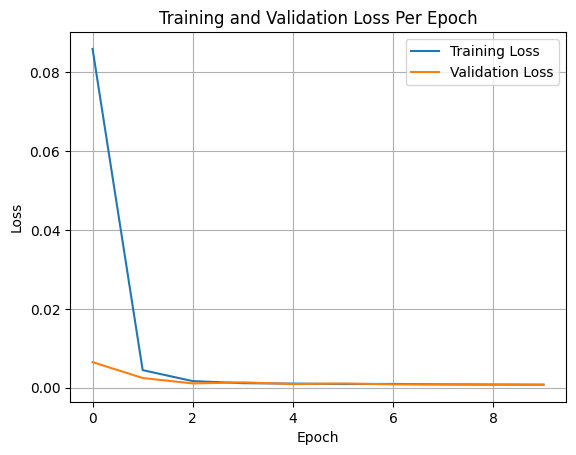

In [47]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Save the Model

In [5]:
model_directory = './LSTM_Models/'
os.makedirs(model_directory, exist_ok=True)
model_filename = os.path.join(model_directory, 'lstm_stock_model.h5')